# Bidirectional Recurrent Neural Networks 

In [ ]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/jdariasl/DiplomadoEPM_2019/master/Modulo4/init.py
from init import init; init(force_download=False)

In [ ]:
import sys
if 'google.colab' in sys.modules:
    print ("setting tensorflow version in colab")
    %tensorflow_version 2.x
    %load_ext tensorboard
import tensorflow as tf
tf.__version__

In [4]:
import collections
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
import local.lib.project_tests as tests
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GRU, LSTM, Input, Dense, TimeDistributed, Embedding, Activation, RepeatVector, Bidirectional, Concatenate, Dot
from tensorflow.keras.layers import Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.preprocessing.text import one_hot
from keras.utils import np_utils

In some problems the information required to make a prediction in one point of a sequence, includes not only pass information but also "future" information, i.e., information before and after of the target point in the sequence. This also implies that such informaction must be available to make the perdictions. For instance, in translation problems usually you need to know an entire sentence beforhand in order to translate it correctly.   The bidirectional RNNs are a modification of the standard RNNs that incorporate additional layers which transmit the information from the time $t+1$ to the time $t$. The forward and backward layers do not have any conextion among them. 

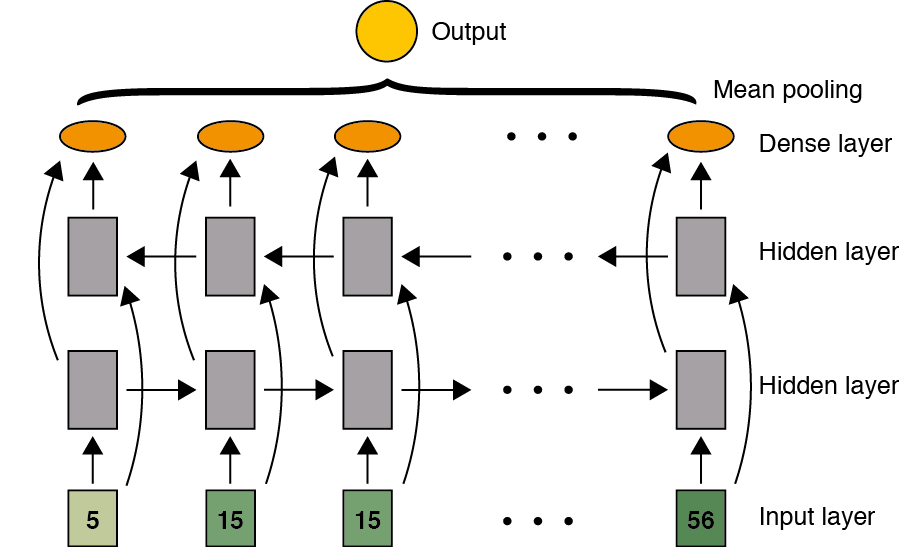

In [6]:
from IPython.display import Image
Image(filename='local/imgs/RNN_arc_3.png', width=1200)
#![alt text](./Images/RNN_arc_3.png "Neuronas")

## Neural Machine Translation

This example is based on the Machine Translation material included in the Deep Learning Specilization offered by Coursera: https://es.coursera.org/specializations/deep-learning

The following model architecture could be used for a full language translation problem, however it would require hundred of thousands of texts, a big computational power (GPU) and hundreds of hours in order to get a fairly accurate model. Therefore, we are going to use a medium sizes datase that includes 137860 sentences in English and French.

In [8]:
english_sentences = tuple(open('local/data/small_vocab_en', 'r'))
french_sentences = tuple(open('local/data/small_vocab_fr', 'r'))

In [9]:
for sample_i in range(2):
    print('small_vocab_en Line {}:  {}'.format(sample_i + 1, english_sentences[sample_i]))
    print('small_vocab_fr Line {}:  {}'.format(sample_i + 1, french_sentences[sample_i]))

small_vocab_en Line 1:  new jersey is sometimes quiet during autumn , and it is snowy in april .

small_vocab_fr Line 1:  new jersey est parfois calme pendant l' automne , et il est neigeux en avril .

small_vocab_en Line 2:  the united states is usually chilly during july , and it is usually freezing in november .

small_vocab_fr Line 2:  les états-unis est généralement froid en juillet , et il gèle habituellement en novembre .



In [10]:
english_words_counter = collections.Counter([word for sentence in english_sentences for word in sentence.split()])
french_words_counter = collections.Counter([word for sentence in french_sentences for word in sentence.split()])

print('{} English words.'.format(len([word for sentence in english_sentences for word in sentence.split()])))
print('{} unique English words.'.format(len(english_words_counter)))
print('10 Most common words in the English dataset:')
print('"' + '" "'.join(list(zip(*english_words_counter.most_common(10)))[0]) + '"')
print()
print('{} French words.'.format(len([word for sentence in french_sentences for word in sentence.split()])))
print('{} unique French words.'.format(len(french_words_counter)))
print('10 Most common words in the French dataset:')
print('"' + '" "'.join(list(zip(*french_words_counter.most_common(10)))[0]) + '"')

1823250 English words.
227 unique English words.
10 Most common words in the English dataset:
"is" "," "." "in" "it" "during" "the" "but" "and" "sometimes"

1961295 French words.
355 unique French words.
10 Most common words in the French dataset:
"est" "." "," "en" "il" "les" "mais" "et" "la" "parfois"


### Tokenize

In [11]:
def tokenize(x):
    x_tk = Tokenizer(char_level = False)
    x_tk.fit_on_texts(x)
    return x_tk.texts_to_sequences(x), x_tk

text_sentences = [
    'The quick brown fox jumps over the lazy dog .',
    'By Jove , my quick study of lexicography won a prize .',
    'This is a short sentence .']
text_tokenized, text_tokenizer = tokenize(text_sentences)
print(text_tokenizer.word_index)
print()
for sample_i, (sent, token_sent) in enumerate(zip(text_sentences, text_tokenized)):
    print('Sequence {} in x'.format(sample_i + 1))
    print('  Input:  {}'.format(sent))
    print('  Output: {}'.format(token_sent))

{'the': 1, 'quick': 2, 'a': 3, 'brown': 4, 'fox': 5, 'jumps': 6, 'over': 7, 'lazy': 8, 'dog': 9, 'by': 10, 'jove': 11, 'my': 12, 'study': 13, 'of': 14, 'lexicography': 15, 'won': 16, 'prize': 17, 'this': 18, 'is': 19, 'short': 20, 'sentence': 21}

Sequence 1 in x
  Input:  The quick brown fox jumps over the lazy dog .
  Output: [1, 2, 4, 5, 6, 7, 1, 8, 9]
Sequence 2 in x
  Input:  By Jove , my quick study of lexicography won a prize .
  Output: [10, 11, 12, 2, 13, 14, 15, 16, 3, 17]
Sequence 3 in x
  Input:  This is a short sentence .
  Output: [18, 19, 3, 20, 21]


### Padding

In [12]:
def pad(x, length=None):
    if length is None:
        length = max([len(sentence) for sentence in x])
    return pad_sequences(x, maxlen = length, padding = 'post')

tests.test_pad(pad)

# Pad Tokenized output
test_pad = pad(text_tokenized)
for sample_i, (token_sent, pad_sent) in enumerate(zip(text_tokenized, test_pad)):
    print('Sequence {} in x'.format(sample_i + 1))
    print('  Input:  {}'.format(np.array(token_sent)))
    print('  Output: {}'.format(pad_sent))

Sequence 1 in x
  Input:  [1 2 4 5 6 7 1 8 9]
  Output: [1 2 4 5 6 7 1 8 9 0]
Sequence 2 in x
  Input:  [10 11 12  2 13 14 15 16  3 17]
  Output: [10 11 12  2 13 14 15 16  3 17]
Sequence 3 in x
  Input:  [18 19  3 20 21]
  Output: [18 19  3 20 21  0  0  0  0  0]


Applying padding to the dataset

In [13]:
def preprocess(x, y):
    preprocess_x, x_tk = tokenize(x)
    preprocess_y, y_tk = tokenize(y)

    preprocess_x = pad(preprocess_x)
    preprocess_y = pad(preprocess_y)

    # Keras's sparse_categorical_crossentropy function requires the labels to be in 3 dimensions
    preprocess_y = preprocess_y.reshape(*preprocess_y.shape, 1)

    return preprocess_x, preprocess_y, x_tk, y_tk

preproc_english_sentences, preproc_french_sentences, english_tokenizer, french_tokenizer =\
preprocess(english_sentences, french_sentences)
    
max_english_sequence_length = preproc_english_sentences.shape[1]
max_french_sequence_length = preproc_french_sentences.shape[1]
english_vocab_size = len(english_tokenizer.word_index) + 1
french_vocab_size = len(french_tokenizer.word_index) + 1

print('Data Preprocessed')
print("Max English sentence length:", max_english_sequence_length)
print("Max French sentence length:", max_french_sequence_length)
print("English vocabulary size:", english_vocab_size)
print("French vocabulary size:", french_vocab_size)

Data Preprocessed
Max English sentence length: 15
Max French sentence length: 21
English vocabulary size: 200
French vocabulary size: 345


In order to see the actual French translation, it is necessary to define a function to decode the network's output.

In [14]:
def logits_to_text(logits, tokenizer):
    index_to_words = {id: word for word, id in tokenizer.word_index.items()}
    index_to_words[0] = '<PAD>'

    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])

print('`logits_to_text` function loaded.')

`logits_to_text` function loaded.


In [15]:
def logits_to_text_en(seq, tokenizer):
    index_to_words = {id: word for word, id in tokenizer.word_index.items()}
    index_to_words[0] = '<PAD>'

    return ' '.join([index_to_words[item] for item in seq])

print('`logits_to_text` function loaded.')

`logits_to_text` function loaded.


In [16]:
preproc_french_sentences.shape

(137860, 21, 1)

### Simple RNN network

Pay attention to the output format and the loss function.

In [17]:
def simple_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    learning_rate = 1e-3
    input_seq = Input(input_shape[1:])
    rnn = GRU(64, return_sequences = True)(input_seq)
    logits = TimeDistributed(Dense(french_vocab_size))(rnn)
    model = Model(input_seq, Activation('softmax')(logits))
    model.compile(loss = 'sparse_categorical_crossentropy', 
                 optimizer = Adam(learning_rate))
    
    return model
#Input and output sequences must have the same length
tmp_x = pad(preproc_english_sentences, max_french_sequence_length)
tmp_x = tmp_x.reshape((-1, preproc_french_sentences.shape[-2], 1))

# Train the neural network
simple_rnn_model = simple_model(
    tmp_x.shape,
    max_french_sequence_length,
    english_vocab_size,
    french_vocab_size)
simple_rnn_model.fit(tmp_x, preproc_french_sentences, batch_size=1024, epochs=10, validation_split=0.2)

# Print prediction(s)
print('Original sentence:')
print(logits_to_text_en(tmp_x[:1].flatten(), english_tokenizer))
print('Translated sentence:')
print(logits_to_text(simple_rnn_model.predict(tmp_x[:1])[0], french_tokenizer))

Train on 110288 samples, validate on 27572 samples
Epoch 1/10
110288/110288 [==============================] - 3s 25us/sample - loss: 3.4204 - val_loss: 2.5308
Epoch 2/10
110288/110288 [==============================] - 1s 11us/sample - loss: 2.4163 - val_loss: 2.2949
Epoch 3/10
110288/110288 [==============================] - 1s 13us/sample - loss: 2.1742 - val_loss: 2.0402
Epoch 4/10
110288/110288 [==============================] - 1s 11us/sample - loss: 1.9165 - val_loss: 1.8036
Epoch 5/10
110288/110288 [==============================] - 1s 11us/sample - loss: 1.7325 - val_loss: 1.6715
Epoch 6/10
110288/110288 [==============================] - 1s 11us/sample - loss: 1.6291 - val_loss: 1.5894
Epoch 7/10
110288/110288 [==============================] - 1s 11us/sample - loss: 1.5587 - val_loss: 1.5284
Epoch 8/10
110288/110288 [==============================] - 1s 12us/sample - loss: 1.5046 - val_loss: 1.4800
Epoch 9/10
110288/110288 [==============================] - 1s 12us/sample - 

In [18]:
simple_rnn_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 21, 1)]           0         
_________________________________________________________________
gru (GRU)                    (None, 21, 64)            12864     
_________________________________________________________________
time_distributed (TimeDistri (None, 21, 345)           22425     
_________________________________________________________________
activation (Activation)      (None, 21, 345)           0         
Total params: 35,289
Trainable params: 35,289
Non-trainable params: 0
_________________________________________________________________


## Using word2vec

In [19]:
def embed_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    learning_rate = 1e-3
    rnn = GRU(64, return_sequences=True, activation="relu")
    
    embedding = Embedding(english_vocab_size, 64, input_length=input_shape[1]) 
    logits = TimeDistributed(Dense(french_vocab_size, activation="softmax"))
    
    model = Sequential()
    #em can only be used in first layer --> Keras Documentation
    model.add(embedding)
    model.add(rnn)
    model.add(logits)
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=Adam(learning_rate))
    
    return model
#Input and output sequences must have the same length
tmp_x = pad(preproc_english_sentences, max_french_sequence_length)
tmp_x = tmp_x.reshape((-1, preproc_french_sentences.shape[-2]))

embeded_model = embed_model(
    tmp_x.shape,
    max_french_sequence_length,
    english_vocab_size,
    french_vocab_size)

embeded_model.fit(tmp_x, preproc_french_sentences, batch_size=1024, epochs=10, validation_split=0.2)

# Print prediction(s)
print('Original sentence:')
print(logits_to_text_en(tmp_x[:1].flatten(), english_tokenizer))
print('Translated sentence:')
print(logits_to_text(embeded_model.predict(tmp_x[:1])[0], french_tokenizer))

Train on 110288 samples, validate on 27572 samples
Epoch 1/10
110288/110288 [==============================] - 3s 23us/sample - loss: 3.7381 - val_loss: 2.7272
Epoch 2/10
110288/110288 [==============================] - 2s 18us/sample - loss: 2.3785 - val_loss: 2.0617
Epoch 3/10
110288/110288 [==============================] - 2s 19us/sample - loss: 1.7115 - val_loss: 1.4251
Epoch 4/10
110288/110288 [==============================] - 2s 19us/sample - loss: 1.2139 - val_loss: 1.0401
Epoch 5/10
110288/110288 [==============================] - 2s 20us/sample - loss: 0.9302 - val_loss: 0.8363
Epoch 6/10
110288/110288 [==============================] - 3s 24us/sample - loss: 0.7752 - val_loss: 0.7646
Epoch 7/10
110288/110288 [==============================] - 2s 18us/sample - loss: 0.6825 - val_loss: 0.6367
Epoch 8/10
110288/110288 [==============================] - 2s 17us/sample - loss: 0.6069 - val_loss: 0.5742
Epoch 9/10
110288/110288 [==============================] - 2s 18us/sample - 

## Bidirectional RNN

In [20]:
def bd_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
   
    learning_rate = 1e-3
    model = Sequential()
    model.add(Embedding(english_vocab_size, 64, input_length=input_shape[1])) 
    model.add(Bidirectional(GRU(64, return_sequences = True, dropout = 0.1)))
    model.add(TimeDistributed(Dense(french_vocab_size, activation = 'softmax')))
    model.compile(loss = sparse_categorical_crossentropy, 
                 optimizer = Adam(learning_rate))
    return model

#Input and output sequences must have the same length
tmp_x = pad(preproc_english_sentences, max_french_sequence_length)
tmp_x = tmp_x.reshape((-1, preproc_french_sentences.shape[-2]))

bidi_model = bd_model(
    tmp_x.shape,
    max_french_sequence_length,
    english_vocab_size,
    french_vocab_size)

bidi_model.fit(tmp_x, preproc_french_sentences, batch_size=1024, epochs=10, validation_split=0.2)

# Print prediction(s)
# Print prediction(s)
print('Original sentence:')
print(logits_to_text_en(tmp_x[:1].flatten(), english_tokenizer))
print('Translated sentence:')
print(logits_to_text(bidi_model.predict(tmp_x[:1])[0], french_tokenizer))

Train on 110288 samples, validate on 27572 samples
Epoch 1/10
110288/110288 [==============================] - 4s 32us/sample - loss: 3.4223 - val_loss: 2.5228
Epoch 2/10
110288/110288 [==============================] - 2s 17us/sample - loss: 2.2360 - val_loss: 1.7909
Epoch 3/10
110288/110288 [==============================] - 2s 18us/sample - loss: 1.5004 - val_loss: 1.2732
Epoch 4/10
110288/110288 [==============================] - 2s 17us/sample - loss: 1.1395 - val_loss: 1.0042
Epoch 5/10
110288/110288 [==============================] - 2s 18us/sample - loss: 0.9278 - val_loss: 0.8329
Epoch 6/10
110288/110288 [==============================] - 2s 17us/sample - loss: 0.7842 - val_loss: 0.7075
Epoch 7/10
110288/110288 [==============================] - 2s 18us/sample - loss: 0.6785 - val_loss: 0.6150
Epoch 8/10
110288/110288 [==============================] - 2s 17us/sample - loss: 0.5996 - val_loss: 0.5475
Epoch 9/10
110288/110288 [==============================] - 2s 18us/sample - 

## Encoder-decoder

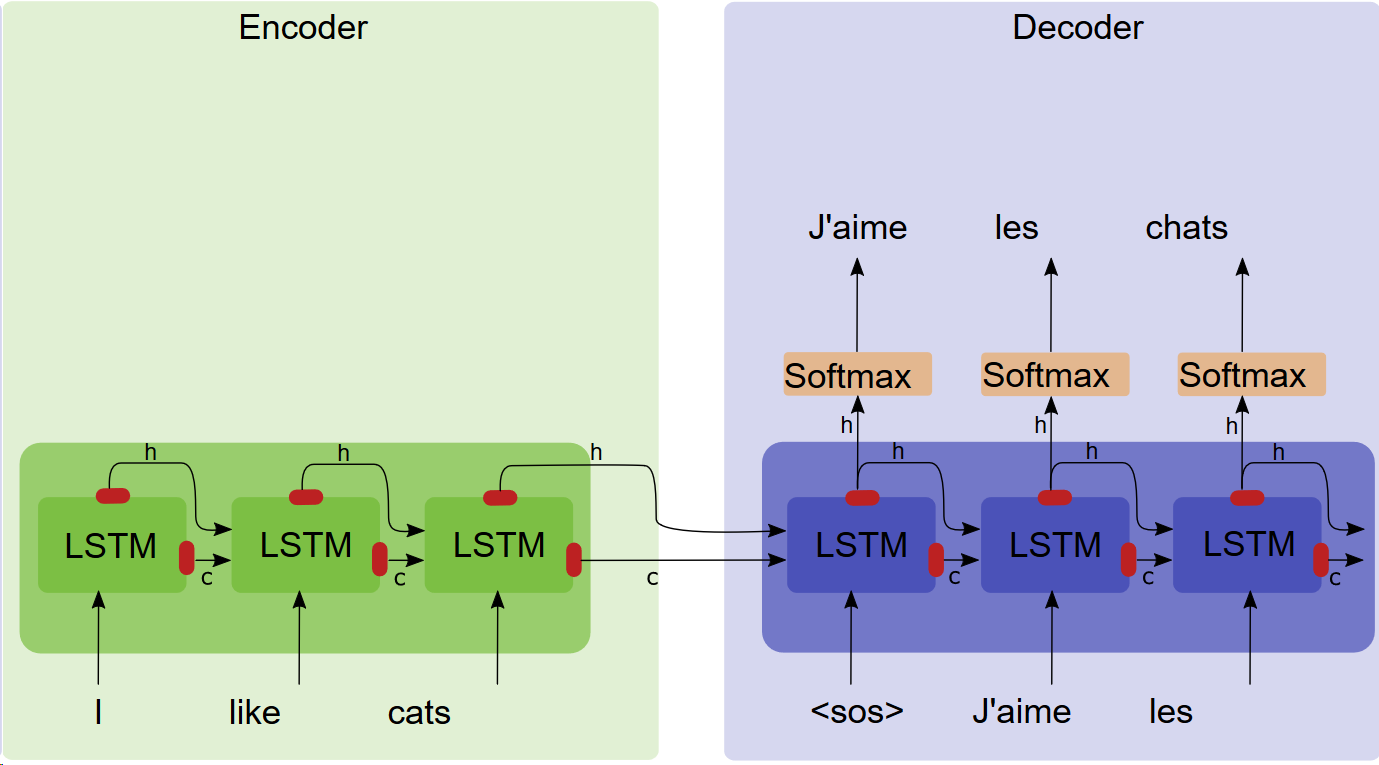

In [21]:
from IPython.display import Image
Image(filename='local/imgs/EDA.png', width=1200)
#![alt text](./Images/EDA.png "Encoder-Decoder")

Image taken from: https://towardsdatascience.com/light-on-math-ml-attention-with-keras-dc8dbc1fad39

In [22]:
def encdec_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
  
    learning_rate = 0.005
    model = Sequential()
    model.add(Embedding(input_dim=english_vocab_size, output_dim=64, input_length=input_shape[1])) 
    model.add(Bidirectional(GRU(256, return_sequences = False)))
    model.add(RepeatVector(output_sequence_length))
    model.add(GRU(256, return_sequences = True))
    model.add(TimeDistributed(Dense(french_vocab_size, activation = 'softmax')))
    
    model.compile(loss = 'sparse_categorical_crossentropy', 
                 optimizer = Adam(learning_rate))
    return model

tmp_x = pad(preproc_english_sentences, max_english_sequence_length)
#tmp_x = tmp_x.reshape((-1, preproc_english_sentences.shape[-2]))

encodeco_model = encdec_model(
    tmp_x.shape,
    max_french_sequence_length,
    english_vocab_size,
    french_vocab_size)

encodeco_model.fit(tmp_x, preproc_french_sentences, batch_size=1024, epochs=20, validation_split=0.2)

print('Original sentence:')
print(logits_to_text_en(tmp_x[:1].flatten(), english_tokenizer))
print('Translated sentence:')
print(logits_to_text(encodeco_model.predict(tmp_x[:1])[0], french_tokenizer))

Train on 110288 samples, validate on 27572 samples
Epoch 1/20
110288/110288 [==============================] - 6s 53us/sample - loss: 2.4805 - val_loss: 1.7925
Epoch 2/20
110288/110288 [==============================] - 4s 35us/sample - loss: 1.4851 - val_loss: 1.2254
Epoch 3/20
110288/110288 [==============================] - 4s 34us/sample - loss: 1.0558 - val_loss: 0.9061
Epoch 4/20
110288/110288 [==============================] - 4s 36us/sample - loss: 0.8211 - val_loss: 0.6893
Epoch 5/20
110288/110288 [==============================] - 3s 31us/sample - loss: 0.5993 - val_loss: 0.5049
Epoch 6/20
110288/110288 [==============================] - 3s 31us/sample - loss: 0.4274 - val_loss: 0.3543
Epoch 7/20
110288/110288 [==============================] - 4s 34us/sample - loss: 0.2929 - val_loss: 0.3023
Epoch 8/20
110288/110288 [==============================] - 4s 33us/sample - loss: 0.2253 - val_loss: 0.2107
Epoch 9/20
110288/110288 [==============================] - 4s 32us/sample - 

In [23]:
encodeco_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 15, 64)            12800     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 512)               494592    
_________________________________________________________________
repeat_vector (RepeatVector) (None, 21, 512)           0         
_________________________________________________________________
gru_4 (GRU)                  (None, 21, 256)           591360    
_________________________________________________________________
time_distributed_3 (TimeDist (None, 21, 345)           88665     
Total params: 1,187,417
Trainable params: 1,187,417
Non-trainable params: 0
_________________________________________________________________


## Metrics in a real context

From: wikipedia

**BLEU (bilingual evaluation understudy)** is an algorithm for evaluating the quality of text which has been machine-translated from one natural language to another. Quality is considered to be the correspondence between a machine's output and that of a human: "the closer a machine translation is to a professional human translation, the better it is" – this is the central idea behind BLEU. BLEU was one of the first metrics to claim a high correlation with human judgements of quality, and remains one of the most popular automated and inexpensive metrics.

Scores are calculated for individual translated segments—generally sentences—by comparing them with a set of good quality reference translations. Those scores are then averaged over the whole corpus to reach an estimate of the translation's overall quality. Intelligibility or grammatical correctness are not taken into account

NLTK provides the sentence_bleu() function for evaluating a candidate sentence against one or more reference sentences.